In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import re
from collections import Counter
from statistics import median

In [3]:
df0 = pd.read_csv("train.csv")
df1 = pd.read_csv("test.csv")

In [4]:
df0["Set"] = [0]*len(df0)
df1["Set"] = [1]*len(df1)

In [5]:
df = pd.merge(df0, df1, how="outer")

In [6]:
## 범주형 Dummy 생성
df = pd.get_dummies(df, columns=["Sex"]).drop(["Sex_male"], axis=1)
df = df.join(pd.get_dummies(df[["Embarked"]], columns=["Embarked"]))

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Set', 'Sex_female',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [8]:
## 일관된 형식을 위해 Name2 생성
df["Name2"] = df["Name"].replace({
    'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")':
    'Duff Gordon, Mrs. Morgan',
    'Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")':
    'Duff Gordon, Mr. Morgan',
    'Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")':
    'Mayne, Mrs. Villiers',
    'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")':
    'Phillips, Mrs. Kate Louise Phillips Marshall',
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)':
    'Rothes, Countess. Lucy Noel Martha Dyer-Edwards',
    'Yrois, Miss. Henriette ("Mrs Harbeck")':
    'Yrois, Mrs. Harbeck'})

In [9]:
## Title
df["Title"] = df["Name2"].apply(lambda x: x.split(",")[1].strip().split(".")[0].strip())
df["Title"] = df["Title"].replace({"Don": "Mr", "Dona": "Ms", "Mlle": "Ms", "Mme": "Ms"})

In [10]:
df["Title"] = df["Title"].replace({"Capt": "Mr", "Col": "Mr", "Countess": "Ms",
                                   "Dr": "Mr", "Jonkheer": "Mr", "Major": "Mr", "Rev": "Mr"})

In [11]:
## Last Name
df["LName"] = df["Name2"].apply(lambda x: x.split(",")[0].strip())
df["LName"] = df["LName"].apply(lambda x: re.sub('[-()\'\"]', "", x.title()))
df["LName"] = df["LName"].apply(lambda x: x.replace(" ", ""))

In [12]:
## First Name
df["FName"] = df["Name2"].apply(lambda x: x.split(".")[1].strip())
df["FName"] = df["FName"].apply(lambda x: x.replace("/", " ").split(" ")[0].strip())
df["FName"] = df["FName"].apply(lambda x: re.sub('[-()\'\"]', "", x))

In [13]:
df[["Name2", "Title", "LName", "FName"]].head()

,Name2,Title,LName,FName
0,"Braund, Mr. Owen Harris",Mr,Braund,Owen
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,Cumings,John
2,"Heikkinen, Miss. Laina",Miss,Heikkinen,Laina
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,Futrelle,Jacques
4,"Allen, Mr. William Henry",Mr,Allen,William


In [14]:
## 일관된 형식을 위해 Ticket2 생성
df["Ticket2"] = df["Ticket"].apply(lambda x: re.sub('[./]', "", x.upper()))
df["Ticket2"] = df["Ticket2"].apply(lambda x: "/".join(x.rsplit(" ", 1)))
df["Ticket2"] = df["Ticket2"].apply(lambda x: x.replace(" ", ""))

In [15]:
df[["Ticket2"]].head()

,Ticket2
0,A5/21171
1,PC/17599
2,STONO2/3101282
3,113803
4,373450


In [16]:
## 가정: 부부이면 티켓 동일하다
## 예외: LName FName 같은데 티켓 2종류 >> 9건
Counter({k: len(set(v["Ticket2"].tolist()))
         for k, v in df[["LName", "FName", "Ticket2"]].groupby(["LName", "FName"])}.values())

Counter({1: 1174, 2: 9})

In [17]:
{k: set(v["Ticket2"].tolist())
 for k, v in df[["Name2", "LName", "FName", "Ticket2"]].groupby(["LName", "FName"])
 if len(set(v["Ticket2"].tolist())) > 1}

{('Connolly', 'Kate'): {'330972', '370373'},
 ('Crosby', 'Edward'): {'112901', 'WEP/5735'},
 ('Davies', 'John'): {'A4/48871', 'CA/33112'},
 ('DuffGordon', 'Morgan'): {'11755', 'PC/17485'},
 ('Elias', 'Joseph'): {'2675', '2690'},
 ('Flynn', 'John'): {'368323', 'PC/17474'},
 ('Kelly', 'James'): {'330911', '363592'},
 ('Svensson', 'Johan'): {'347060', '7538'},
 ('Williams', 'Charles'): {'244373', 'PC/17597'}}

In [18]:
cols = ["PassengerId", "Name2", "Ticket2", "Pclass", "Embarked", "Age", "SibSp", "Parch"]

In [19]:
## 조건 필요: 결혼 & 남녀
df[(df.LName=="Connolly")&(df.FName=="Kate")][cols]
df[(df.LName=="Flynn")&(df.FName=="John")][cols]
df[(df.LName=="Kelly")&(df.FName=="James")][cols]
df[(df.LName=="Svensson")&(df.FName=="Johan")][cols]
df[(df.LName=="Williams")&(df.FName=="Charles")][cols]

,PassengerId,Name2,Ticket2,Pclass,Embarked,Age,SibSp,Parch
17,18,"Williams, Mr. Charles Eugene",244373,2,S,NaN,0,0
155,156,"Williams, Mr. Charles Duane",PC/17597,1,C,51.0,0,1


In [20]:
## 조건 필요: Jr 제외
df[(df.LName=="Davies")&(df.FName=="John")][cols]
df[(df.LName=="Elias")&(df.FName=="Joseph")][cols]

,PassengerId,Name2,Ticket2,Pclass,Embarked,Age,SibSp,Parch
532,533,"Elias, Mr. Joseph Jr",2690,3,C,17.0,1,1
1228,1229,"Elias, Mr. Joseph",2675,3,C,39.0,0,2


In [21]:
## 티켓2 수정
df[(df.LName=="Crosby")&(df.FName=="Edward")][cols]
df[(df.LName=="Crosby")][cols]

,PassengerId,Name2,Ticket2,Pclass,Embarked,Age,SibSp,Parch
540,541,"Crosby, Miss. Harriet R",WEP/5735,1,S,36.0,0,2
745,746,"Crosby, Capt. Edward Gifford",WEP/5735,1,S,70.0,1,1
1196,1197,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",112901,1,S,64.0,1,1


In [22]:
df[(df.Ticket2=="11755")|(df.Ticket2=="PC/17485")][cols]

,PassengerId,Name2,Ticket2,Pclass,Embarked,Age,SibSp,Parch
309,310,"Francatelli, Miss. Laura Mabel",PC/17485,1,C,30.0,0,0
556,557,"Duff Gordon, Mrs. Morgan",11755,1,C,48.0,1,0
599,600,"Duff Gordon, Mr. Morgan",PC/17485,1,C,49.0,1,0


In [23]:
## id 600번 티켓2 수정
df[(df.LName=="DuffGordon")&(df.FName=="Morgan")][cols]
df[(df.Ticket2=="11755")|(df.Ticket2=="PC/17485")][cols]

,PassengerId,Name2,Ticket2,Pclass,Embarked,Age,SibSp,Parch
309,310,"Francatelli, Miss. Laura Mabel",PC/17485,1,C,30.0,0,0
556,557,"Duff Gordon, Mrs. Morgan",11755,1,C,48.0,1,0
599,600,"Duff Gordon, Mr. Morgan",PC/17485,1,C,49.0,1,0


In [24]:
#######################################################################

In [25]:
## Spouse
sp = {k: v["PassengerId"].tolist() for k, v in df[
    (df["SibSp"] > 0) &
    (df["Title"].apply(lambda x: x in ["Mr", "Mrs"])) &
    (df["Name2"].apply(lambda x: " Jr" not in x))].groupby(["LName", "FName", "Ticket2"])
      if (len(v["PassengerId"]) > 1) &
      (sum([df[df["PassengerId"]==x]["Sex_female"].values[0] for x in v["PassengerId"].tolist()])==1 )}

In [26]:
## [Mr, Mrs] 순서로 정렬
## 코드 합쳐서 나이까지 한 번에
sp = {(k if df[df["PassengerId"]==v[0]]["Sex_female"].values[0]==0 else k):
      (v if df[df["PassengerId"]==v[0]]["Sex_female"].values[0]==0 else list(reversed(v)))
      for k, v in sp.items()}

sp = {k: [(v[0], df[df["PassengerId"]==v[0]]["Age"].values[0]),
          (v[1], df[df["PassengerId"]==v[1]]["Age"].values[0])]
      for k, v in sp.items()}

In [27]:
list(sp.items())[0]

(('Abelson', 'Samuel', 'PPP/3381'), [(309, 30.0), (875, 28.0)])

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  3.,  8., 38., 18., 13.,  3.,  1.]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25]),
 <a list of 13 Patch objects>)

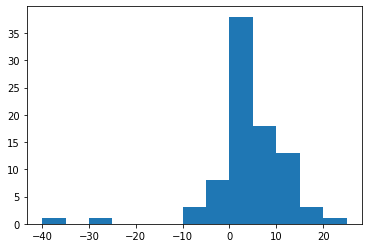

In [28]:
## 배우자 나이 차이
diff = [v[0][1] - v[1][1] for v in sp.values()]
plt.hist(diff, bins=range(-40, 30, 5))

In [29]:
"median: {}".format(round(median([v for v in diff if np.isnan(v)==False]), 3))

'median: 4.0'

In [30]:
## 중앙값 활용해서 결측값 처리
df["Age2"] = df["Age"].copy()

for v in sp.values():
    if (np.isnan(v[0][1])==True) & (np.isnan(v[1][1])==False):
        df.loc[df["PassengerId"]==v[0][0], "Age2"] = v[1][1] + 3.5
    elif (np.isnan(v[0][1])==False) & (np.isnan(v[1][1])==True):
        df.loc[df["PassengerId"]==v[1][0], "Age2"] = v[0][1] - 3.5